These codes demonstrates Fidoc (Fineup with don't care term) imprementation in Python to create Phase Only Hologram(POH).

Propagation is simulated with Angular Spectrum Method

In [4]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
try:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass
print(tf.__version__)
# Print list of all available physical devices (including GPUs)
physical_devices = tf.config.list_physical_devices()
print("Available Physical Devices:", physical_devices)
# Print list of all available logical devices
logical_devices = tf.config.list_logical_devices()
print("Available Logical Devices:", logical_devices)
# Check if GPU is available
gpu_available = tf.config.experimental.list_physical_devices('GPU')
if gpu_available:
    print("GPU is available and recognized by TensorFlow.")
else:
    print("No GPU is available or TensorFlow doesn't recognize the GPU.")

import os, tarfile
data_size = 960
import tensorflow as tf
import tensorflow.keras.backend as K
import cv2,math,torch,time
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append("C:/Users/Unknown/Documents/VSCode/Jupyter")
from image_eval import psnr,ssim,msssim,blinds_ii,calculate_vif,psnr_hvs,NPCC,tensor_reshaper
def imresize(array,shape):
    resized_images = np.empty((array.shape[0], shape, shape), dtype=array.dtype)
    for i in range(array.shape[0]):
        # Extract the current image
        current_image = array[i, :, :]  # Assuming the channel axis is the last one
        # Resize the image using cv2.resize
        resized_image = cv2.resize(current_image, (shape, shape), interpolation=cv2.INTER_LINEAR)
        # Add the resized image to the new array
        resized_images[i, :, :] = resized_image

    return resized_images

output_size = 640,640
x_test = np.load(f'C:/Users/Unknown/Documents/VSCode/Jupyter/Validation{data_size}_half.npy')
resize=1
if resize:
    shape=output_size[0]
    x_test=imresize(x_test,shape)
x_test=tf.image.convert_image_dtype(x_test,dtype='float32')
x_test = tf.expand_dims(x_test, axis=-1)
#confirm they are idential except N

def PropagationLayer(input,mode=None):#Angular spectrum method for input or output
    lamda = 532e-9 #lambda is the reserved word
    dp = 8e-6 #pixel size of SLM you use
    z = 100e-3 #propagation distance you assume
    pad_m = input.shape[0] // 2
    pad_n = input.shape[1] // 2
    if mode=="input":
        z = -z #propagation distance,bu reverse direction
    Lx = dp * input.shape[1]
    Ly = dp * input.shape[0]
    f_max = 0.5 / dp
    du = 1.0 / Lx
    dv = 1.0 / Ly
    x_range = tf.range(-f_max, f_max, du, dtype=tf.float32)
    y_range = tf.range(-f_max, f_max, dv, dtype=tf.float32)
    fx, fy = tf.meshgrid(x_range, y_range)
    FH = tf.signal.fftshift(tf.signal.ifft2d(tf.signal.fftshift(input)))
    real_part = tf.math.cos(2 * math.pi * z * tf.sqrt(1 /(lamda**2) - fx**2 - fy**2))
    imaginary_part = tf.math.sin(2 * math.pi * z * tf.sqrt(1 /(lamda**2) - fx**2 - fy**2))
    P = tf.complex(real_part, imaginary_part)#normal ASM kernel
    #define frequency limit for sampling theorem(not for iteratives)
    '''fx_max = tf.math.divide(input.shape[0] * dp, lamda * tf.math.sqrt((2 * z) ** 2 + (input.shape[0]  * dp) ** 2))
    fy_max = tf.math.divide(input.shape[1] * dp, lamda * tf.math.sqrt((2 * z) ** 2 + (input.shape[1]  * dp) ** 2))
    P = tf.where(tf.math.logical_and(tf.abs(fx) < fx_max, tf.abs(fy) < fy_max), x=P, y=0.0)#band-limiting mask for kernal(sampling theorem)'''
    U = tf.signal.fftshift(tf.signal.fft2d(tf.signal.fftshift(FH * P)))#kernel applied in Fourier domain
    return U


2.10.0
Available Physical Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Available Logical Devices: [LogicalDevice(name='/device:CPU:0', device_type='CPU'), LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU is available and recognized by TensorFlow.
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Unknown\Documents\VSCode\Jupyter\.venv\lib\site-packages\lpips\weights\v0.1\alex.pth


Fidoc

In [4]:
outputs=[]
holos=[]
times=[]
itr=[443,36,549,96,716,106,429,35,114,120]#investigated results
losses=[0.0031687617,0.007647574,0.0008711219,0.002143085,0.0034216642,0.0072951317,0.0015817881,0.006794274,0.0023046136,0.0032616258]#to original input
ssims=[0.92622054,0.9291606,0.9583627,0.9056995,0.86980915,0.8800331,0.92664516,0.80549884,0.8779177,0.88468236]#to original input
msssims=[0.98613524,0.9905861,0.990411,0.98473185,0.9667086,0.9825239,0.9891699,0.96913934,0.9743859,0.97880745]
Modified=[0.0014,0.0013,0.001,0.001,0.001,0.001,0.001,0.0011,0.001,0.001]#ralative loss to DNN output inpuy case
inputs=x_test[21:31]#float32,
del x_test#memory save
for num in range(10):
    criteria=losses[num]#NPCC loss between DNN output and Fidoc output
    ssim_val=msssims[num]
    # Load image
    input= inputs[num]#float32
    #input=tf.squeeze(input,axis=-1)
    input_img=np.sqrt(input)

    imsize=input.shape
    # Zero padding but be aware of SLM res
    padding_numy = imsize[0] // 2
    padding_numx = imsize[1] // 2
    '''padding_numy = (1080-640)// 2
    padding_numx = padding_numy'''

    inputd = np.pad(input_img, ((padding_numy, padding_numy), (padding_numx, padding_numx)))
    # ROI after zero padding
    ROIy = slice(padding_numy, imsize[0] + padding_numy)
    ROIx = slice(padding_numx, imsize[1] + padding_numx)
    max_iteration = 1500
    itr2 = 0
    Eval = []
    Eval2 =[]
    alpha = 0.8
    gamma=0.9
    # Initial step before iteration
    phi = tf.cast(np.random.rand(*inputd.shape) * 2 * math.pi,dtype='float32')
    A = tf.complex(inputd, 0.0) * tf.math.exp(tf.complex(0.0, phi))
    # Define don't care term as zero padding method
    M = tf.pad(np.ones_like(input_img, dtype=np.float32), ((padding_numy, padding_numy), (padding_numx, padding_numx)))

    # Iterative phase retrieval
    tic = time.time()
    while (itr2 == 0 or (quality3>criteria)) and itr2 < max_iteration:
        B = PropagationLayer(A,mode='input')
        C = tf.math.exp(tf.complex(0.0, tf.math.angle(B)))  # POH Hk'
        D = PropagationLayer(C,mode='output')  # Ak' back-prop
        A = tf.complex(M*(tf.abs(inputd) + alpha * (tf.abs(inputd) - tf.abs(D))),0.0) + tf.complex((gamma*(1-M)*tf.abs(D)),0.0)*tf.math.exp(tf.complex(0.0, tf.math.angle(D)))   # Ak+1, constrain

        D=tf.expand_dims(D, axis=-1)
        #quality =  psnr(tensor_reshaper(original),tensor_reshaper(tf.square(tf.abs(D[ROIy, ROIx]))))#for monitor the whole process
        #quality2 = msssim(original,tf.square(tf.abs(D[ROIy, ROIx])))
        quality3 = NPCC(tensor_reshaper(input),tensor_reshaper(tf.square(tf.abs(D[ROIy, ROIx]))))#it is metrics for stopping
        #Eval.append(quality)
        #Eval2.append(quality3)
        itr2 += 1
    calc_time = time.time() - tic
    print(itr2)
    print(str(calc_time) + 's with evaluation')
    print(NPCC(input,tf.square(tf.abs(D[ROIy, ROIx]))).numpy())

    #without cpu interruption by evaluation, numpy append...
    #use same phi(initial condition) and same iteration time
    max_iteration = itr2
    itr2 = 0
    A = tf.complex(inputd, 0.0) * tf.math.exp(tf.complex(0.0, phi))

    # Define don't care term as zero padding method
    M = tf.pad(np.ones_like(input_img, dtype=np.float32), ((padding_numy, padding_numy), (padding_numx, padding_numx)))

    # Iterative phase retrieval
    tic = time.time()
    while (itr2 == 0 or itr2 < max_iteration):
        B = PropagationLayer(A,mode='input')
        C = tf.math.exp(tf.complex(0.0, tf.math.angle(B)))  # POH Hk'
        D = PropagationLayer(C,mode='output')  # Ak' back-prop
        A = tf.complex(M*(tf.abs(inputd) + alpha * (tf.abs(inputd) - tf.abs(D))),0.0) + tf.complex((gamma*(1-M)*tf.abs(D)),0.0)*tf.math.exp(tf.complex(0.0, tf.math.angle(D)))   # Ak+1, constrain
        itr2 += 1
    calc_time = time.time() - tic
    print(itr2)
    print(str(calc_time) + 's for im'+str(num+21))
    times.append(calc_time)
    tmp=tf.square(tf.abs(D[ROIy, ROIx])).numpy()
    tmp2=tf.math.angle(C).numpy()
    outputs.append(tmp)
    holos.append(tmp2)
    time.sleep(3)#wait few sec for cooling

443
13.161822319030762s with evaluation
0.0031686425
443
10.434359550476074s for im21
36
1.1309471130371094s with evaluation
0.007442057
36
0.8760240077972412s for im22
1291
45.401387214660645s with evaluation
0.00087052584
1291
36.965601205825806s for im23
86
2.7297534942626953s with evaluation
0.0021300316
86
2.101116895675659s for im24
716
24.052128076553345s with evaluation
0.0034202933
716
19.12796449661255s for im25
38
1.3113079071044922s with evaluation
0.007166147
38
1.1296191215515137s for im26
429
14.845610618591309s with evaluation
0.0015804768
429
11.943658828735352s for im27
35
1.152794599533081s with evaluation
0.006585717
35
0.871342658996582s for im28
114
3.6353137493133545s with evaluation
0.0023012757
114
3.4657042026519775s for im29
55
1.8896090984344482s with evaluation
0.003218174
55
1.7165980339050293s for im30


Below is NPCC based result. MS-SSIM based one is recalculated manually for image 3,6,10 (im23,26,30)

In [5]:
for value in times:
    print(str(value))

10.434359550476074
0.8760240077972412
36.965601205825806
2.101116895675659
19.12796449661255
1.1296191215515137
11.943658828735352
0.871342658996582
3.4657042026519775
1.7165980339050293


33 ~ 42sec for 1000 itr with GPU, varies due to RAP(maybe keep good random seed??)

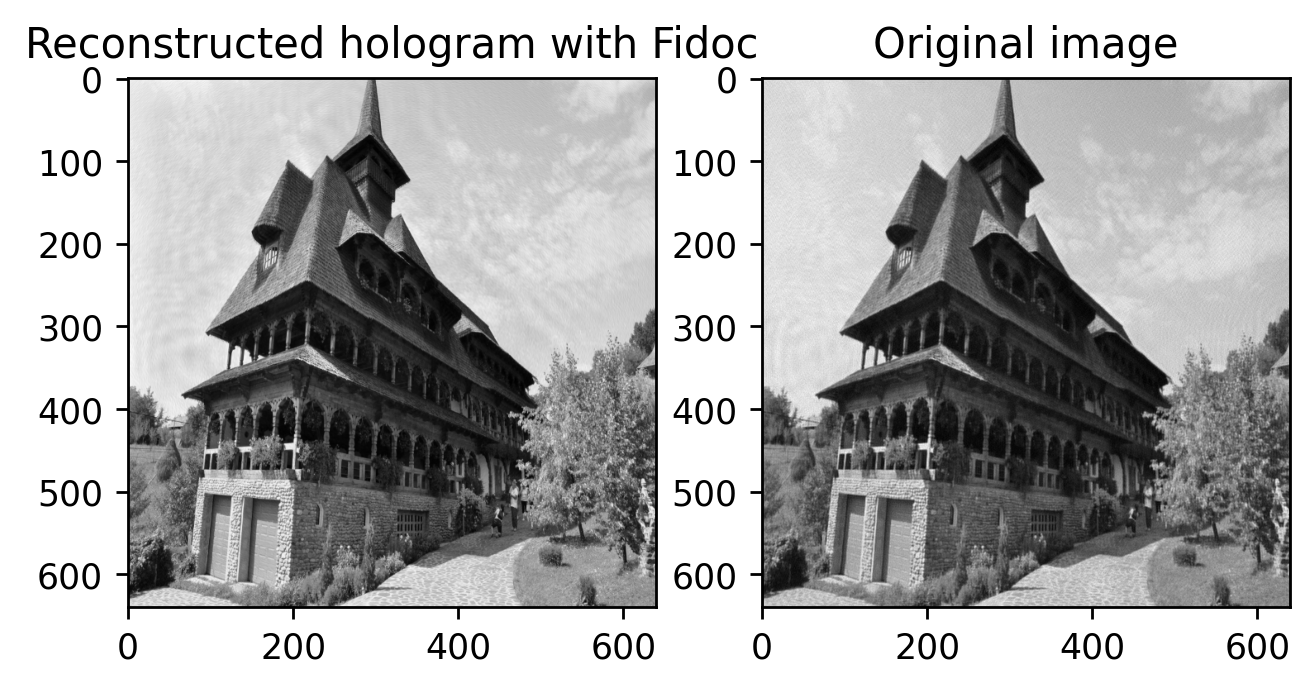

(-0.5, 1279.5, 1279.5, -0.5)

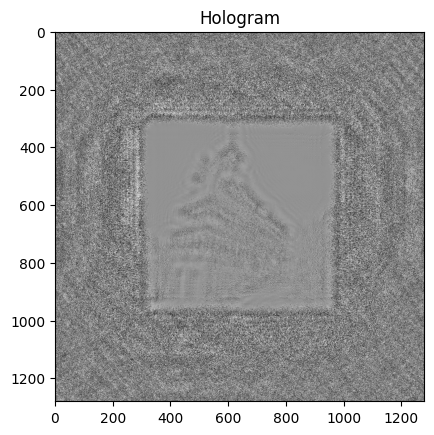

In [7]:
'''plt.figure()
plt.plot(range(1, itr2 + 1), Eval)
plt.title('PSNR plot of Fidoc')
plt.grid(True)

plt.figure()
plt.plot(range(1, itr2 + 1), Eval2)
plt.title('NPCC plot of Fidoc')
plt.grid(True)'''
index=4
plt.figure(figsize=(6, 5),dpi=250)
# Subplot 1: Reconstructed hologram
plt.subplot(1, 2, 1)
plt.imshow(outputs[index], cmap='gray')# tf.math.log(tf.abs(D)) for good visualization
plt.title('Reconstructed hologram with Fidoc')
plt.axis('image')
# Subplot 2: Original image
plt.subplot(1, 2, 2)
plt.imshow(inputs[index], cmap='gray')
plt.title('Original image')
plt.axis('image')
plt.show()

plt.figure()
plt.imshow(holos[index], cmap='gray')
plt.title('Hologram')
plt.axis('image')

In [2]:
from image_eval import Perceptual_loss,loss_fn_alex,Ds
    
for index in range(10):
    #specify which image will be evaluated
    inim=tf.cast(inputs[index],dtype='float32')
    ouim=tf.cast(outputs[index],dtype='float32')
    input_im=tensor_reshaper(inim)
    output_im=tensor_reshaper(ouim)
    if index==9:
        print('im30')
    else:
        print('im2'+str(index+1))
    npcc_values=NPCC(input_im,output_im)
    print('NPCC: ',npcc_values.numpy())

    psnr_values=psnr(input_im,output_im)
    print('PSNR: ',psnr_values[0])

    ssim_values=ssim(input_im,output_im)
    print('SSIM: ',ssim_values[0])

    msssim_values=msssim(input_im,output_im)
    print('MS-SSIM: ',msssim_values[0])

    pl=Perceptual_loss(input_im,output_im)
    print("Perceptual loss : "+str(pl))


    #NHWC to NCHW
    X= torch.from_numpy(input_im.numpy()).permute(0,3,1,2)
    Y=torch.from_numpy(output_im.numpy()).permute(0,3,1,2)
    d = loss_fn_alex(X, Y).detach().numpy()
    print('LPIPS Loss: '+str(d[0,0,0,0]))
    dists_value = Ds(X, Y).detach().numpy() 
    print('DISTS Loss: '+str(dists_value))
    print("\n")

im21
NPCC: 0.0031686425
PSNR: 30.226286
SSIM: 0.94143414
MS-SSIM: 0.97834206
Perceptual loss: 0.43747047
LPIPS Loss: 0.052065298

im22
NPCC: 0.007442057
PSNR: 26.973001
SSIM: 0.93384194
MS-SSIM: 0.9843728
Perceptual loss: 0.7106526
LPIPS Loss: 0.048381843

im23
NPCC: 0.00087052584
PSNR: 36.019703
SSIM: 0.98820525
MS-SSIM: 0.99638534
Perceptual loss: 0.053107396
LPIPS Loss: 0.0199529

im24
NPCC: 0.0021300316
PSNR: 31.78947
SSIM: 0.9154222
MS-SSIM: 0.9849426
Perceptual loss: 0.6207671
LPIPS Loss: 0.060768344

im25
NPCC: 0.005011022
PSNR: 22.200409
SSIM: 0.88433397
MS-SSIM: 0.94503105
Perceptual loss: 0.9584191
LPIPS Loss: 0.11162141

im26
NPCC: 0.007166147
PSNR: 24.555874
SSIM: 0.83127147
MS-SSIM: 0.963678
Perceptual loss: 1.4744668
LPIPS Loss: 0.17807797

im27
NPCC: 0.0015804768
PSNR: 35.514084
SSIM: 0.92883474
MS-SSIM: 0.97380394
Perceptual loss: 0.5030327
LPIPS Loss: 0.07799003

im28
NPCC: 0.006585717
PSNR: 28.815727
SSIM: 0.8152767
MS-SSIM: 0.97216225
Perceptual loss: 1.0190476
LPIPS

In [9]:
#save hologram for lab. Just run after fidoc!
if not os.path.exists('./Fidoc_holos'):
    os.makedirs('./Fidoc_holos')
if not os.path.exists('./Fidoc_reconstructed'):
    os.makedirs('./Fidoc_reconstructed')   
for num in range(10):
    holos_norm=(holos[num]+math.pi)/(2*math.pi)# make it 0 to 1 range from -pi to pi
    POH=(holos_norm*255).astype(np.uint8)
    cv2.imwrite(f'./Fidoc_holos/Fidoc_holo640_10cm_{num+1}.png', POH)
    output=outputs[num]
    output = ((output - np.min(output)) / (np.max(output) - np.min(output))*255.0).astype(np.uint8)
    cv2.imwrite(f'./Fidoc_reconstructed/Fidoc_reconstructed_{num+1}.png', output)